In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().home().absolute() / 'polytrader'))

In [ ]:
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())
logger.addHandler(logging.FileHandler('playground.log'))

In [2]:
from agents.polymarket.polymarket import Polymarket
from agents.trackers.order_book import OrderBook
from typing import Dict

In [3]:
p = Polymarket()

In [4]:
game = p.get_market_by_slug('nba-sas-sac-2024-12-01')
outcome = game.outcomes[1]
# Initialize dictionary to store order books for each outcome
order_books: Dict[str, OrderBook] = {}

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
from collections import deque
import numpy as np

In [6]:
def handle_market_update(outcome: str, message: dict):
    order_book = order_books.get(outcome)
    if order_book is None:
        order_book = OrderBook()
        order_books[outcome] = order_book
    
    if message['event_type'] == 'book':
        order_book.update_from_book(message)
    elif message['event_type'] == 'price_change':
        order_book.update_from_price_change(message)
    elif message['event_type'] == 'last_trade_price':
        order_book.update_last_trade(message)

def create_live_plot(outcome: str, message: dict):
    order_book = order_books.get(outcome)
    if order_book is None:
        return
    now = time.time()
    
    ask_timestamps = order_book.asks_history.columns
    bid_timestamps = order_book.bids_history.columns
    buy_timestamps = order_book.trades[order_book.trades['side'] == 'BUY']['timestamp'].unique()
    sell_timestamps = order_book.trades[order_book.trades['side'] == 'SELL']['timestamp'].unique()

    best_asks = [min(order_book.asks_history[ts].dropna().index) for ts in ask_timestamps]
    best_bids = [max(order_book.bids_history[ts].dropna().index) for ts in bid_timestamps]
    last_buys = [order_book.trades[order_book.trades.timestamp == ts].iloc[0]['price'] for ts in buy_timestamps]
    last_sells = [order_book.trades[order_book.trades.timestamp == ts].iloc[0]['price'] for ts in sell_timestamps]
    mid_prices = [order_book.calculate_vwap_mid_price(timestamp=ts) for ts in ask_timestamps]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert timestamps to relative time (seconds from start)
    relative_ask_times = np.array([float(ts)/1000 for ts in ask_timestamps]) - float(now)
    relative_bid_times = np.array([float(ts)/1000 for ts in bid_timestamps]) - float(now)
    relative_buy_times = np.array([float(ts)/1000 for ts in buy_timestamps]) - float(now)
    relative_sell_times = np.array([float(ts)/1000 for ts in sell_timestamps]) - float(now)
    
    # Plot data
    ax.plot(relative_ask_times, best_asks, 'r-', label='Best Ask', alpha=0.7)
    ax.plot(relative_bid_times, best_bids, 'g-', label='Best Bid', alpha=0.7)
    ax.plot(relative_buy_times, last_buys, 'b.', label='Buy Trades', alpha=0.5, markersize=12)
    ax.plot(relative_sell_times, last_sells, 'r.', label='Sell Trades', alpha=0.5, markersize=12)
    ax.plot(relative_ask_times, mid_prices, 'k-', label='Predicted Mid Price', alpha=0.7)

    # Customize plot
    ax.set_title(f'Live Order Book - {outcome}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Price')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add current values as text
    current_ask = best_asks[-1] if best_asks else None
    current_bid = best_bids[-1] if best_bids else None
    current_buy = last_buys[-1] if last_buys else None
    current_sell = last_sells[-1] if last_sells else None
    current_mid = mid_prices[-1] if mid_prices else None
    text = f'Current Ask: {current_ask:.3f}\n' if current_ask else ''
    text += f'Current Bid: {current_bid:.3f}\n' if current_bid else ''
    text += f'Last Buy: {current_buy:.3f}\n' if current_buy else ''
    text += f'Last Sell: {current_sell:.3f}' if current_sell else ''
    text += f'Current Mid Guess: {current_mid:.3f}' if current_mid else ''
    
    ax.text(0.02, 0.98, text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Display plot
    clear_output(wait=True)
    display(fig)

In [7]:
from pathlib import Path
runtime_s=5*60
save_path = Path().cwd() / 'order_books'
save_path.mkdir(exist_ok=True)

In [8]:
from agents.trackers.market_tracker import MarketChannel
import asyncio
async def track(market_obj):
    # Initialize market channel
    market_channel = MarketChannel(market_obj)

    await market_channel.connect()
    
    counter=0

    # Add callback for specific assets
    market_channel.add_outcome_callback(market_obj.outcomes[0], handle_market_update)
    market_channel.add_outcome_callback(market_obj.outcomes[1], handle_market_update)

    # plot one of them
    market_channel.add_outcome_callback(market_obj.outcomes[0], create_live_plot)

    try:
        # Keep connection alive
        while counter<runtime_s:
            await asyncio.sleep(1)
            counter+=1
    except KeyboardInterrupt:
        await market_channel.close()
        
    print('Closing')
    await market_channel.close()
    for outcome, order_book in order_books.items():
        order_book.save_book(save_path / f'{outcome}_book_history')

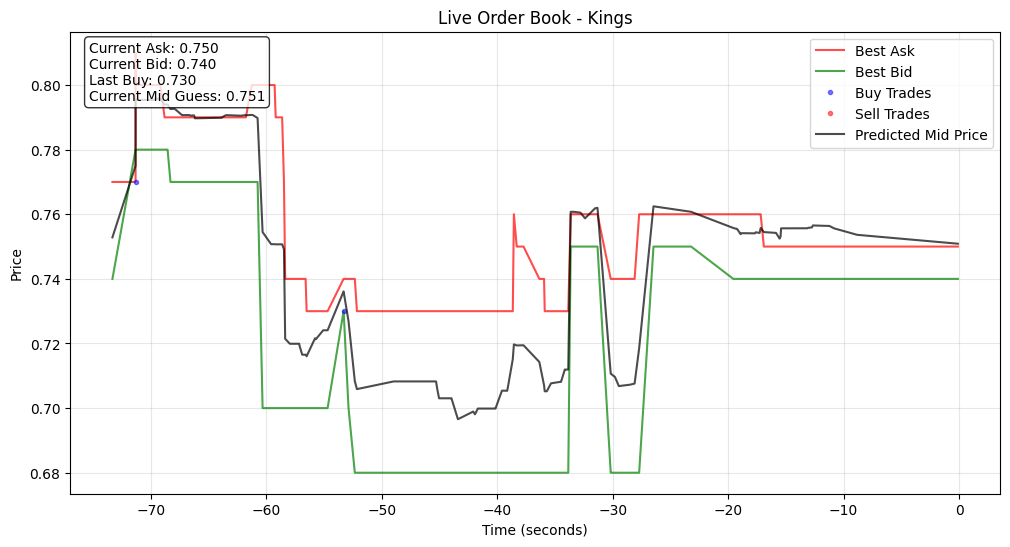

In [ ]:
await track(game)